In [1]:
##################################################
###### UP-DOWN INTEGRATE-AND-FIRE WITH DSAC ######
##################################################
# MV-Buzsaki Lab 2019, based on Jercog et al, 2017 (https://elifesciences.org/articles/22425)

# Loading packages
from brian2 import *
# %matplotlib inline
# from brian2tools import *
import numpy, random, warnings, time, os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
prefs.codegen.target = 'cython'  # use the Python fallback

ModuleNotFoundError: No module named 'brian2'

Performing we_e:0.97 mV, wi_e:-300. uV, we_i:3.5 mV, wi_i:-1. mV...
UD Running...
UD done!
16.2922203540802seconds elapsed...


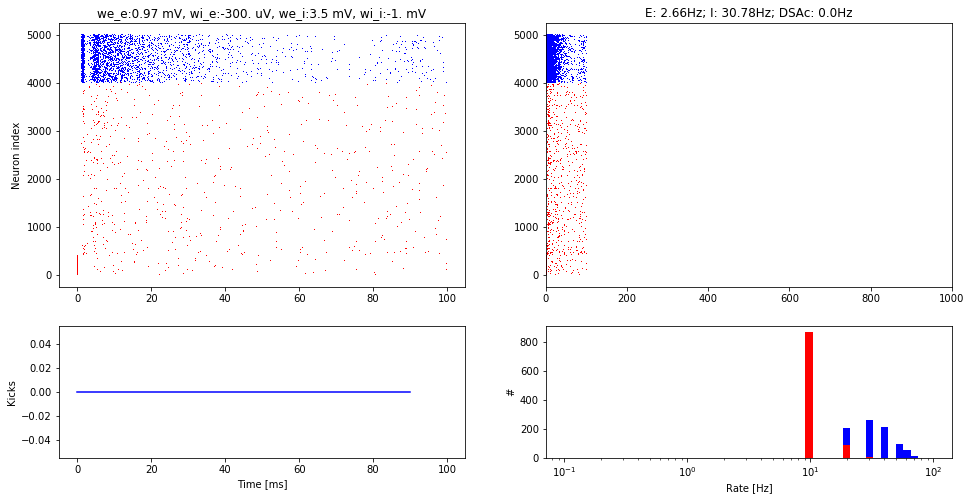

In [2]:
start_scope()

## Model parameters
saveResults = False
N = 5000                 # Network size
dur = .1                 # simulation duration, in seconds
Perc_inh = .2            # percentage of inhibitory neurons
El = -55.53*mV           # Leak potential
sigma = 3*mV             # Gaussian white noise std dev
Perc_dsac = .1           # percentage of DSAc over interneurons
E_ad = -55*mV            # threshold for adaptation current
I_ad = 2*mV              # adaptativ potential

## Connection probs
prob_ee = .1             # Connection probability E to E
prob_ei = .1             # Connection probability E to I
prob_ii = .2             # Connection probability I to I
prob_ie = .3             # Connection probability I to E

# for DSAc
prob_ed = .0             # Connection probability E to DSAc
prob_id = .3             # Connection probability I to DSAc
prob_de = .1             # Connection probability DSAc to E
prob_di = .1             # Connection probability DSAc to I

## Intrinsic parameters 
# for E
taum_e = 20*ms           # membrane time constant
E_e = -51*mV             # reset spikes
Vt_e = -47*mV            # spike threshold

# for I
taum_i = 10*ms           # membrane time constant
E_i = -49.9*mV           # reset spikes
Vt_i = -37*mV            # spike threshold

# for DSAc
taum_d = 40*ms           # membrane time constant
E_d =  -57*mV            # reset spikes
Vt_d = -41*mV            # spike threshold
El_d = -40.95*mV         # Leak potential

## Synapsis parameters
we_e =  .97   *mV          # E to E synaptic weight (voltage), Jercog 1.4
wi_e = -.3  *mV          # I to E synaptic weight, Jercog -.35
we_i = 3.5  *mV          # E to I synaptic weight, Jercog 5
wi_i = -1 *mV          # I to I synaptic weight, Jercog -1
tau_e = 8.0 *ms          # excitation time constant
tau_i = 2.0 *ms          # inhibition time constant

# for DSAc
we_d =  .9  *mV          # E to DSAc synaptic weight
wi_d = -1.5 *mV          # I to DSAc synaptic weight
wd_e =  -.3 *mV          # DSAc to E synaptic weight
wd_i = -1.11*mV          # DSAc to I synaptic weight
tau_id = 20 *ms          # GABAb time constant

# Poisson kiks parameters
k_rate = 2
t_k = np.arange(0,dur,.01)                # Generate t
kiks_t = zeros(len(t_k))                  # Generate kiks(t)
kiks_t[random.sample(range(1,len(t_k)),int(dur/(1/k_rate)))] = 68  # 60
kiks = TimedArray(kiks_t*mV, 10*msecond)

## Internal variables
N_E = int(N - (N * Perc_inh))             # Size of excitatory population
N_Et = int(N_E * .1)
N_I = int(N * Perc_inh)                   # Size of inh population
N_D = int(N_I * Perc_dsac)                # Size of DSAc population, as a function on inh size

## Equation parameters
# for E
eqs_E = ''' 
dv/dt   = (ge+gi+gis-(v-El)+ sigma*sqrt(tau)*xi + kiks(t)*int(rand() <= .1))/tau : volt (unless refractory)
dge/dt  = -ge/tau_e : volt
dgi/dt  = -gi/tau_i : volt
dgis/dt = -gis/tau_id : volt
tau : second
'''

# for I
eqs_I = ''' 
dv/dt   = (ge+gi+gis-(v-El)+ sigma*sqrt(tau)*xi)/tau : volt (unless refractory)
dge/dt  = -ge/tau_e : volt
dgi/dt  = -gi/tau_i : volt
dgis/dt = -gis/tau_id : volt
tau : second
'''

# for DSAc
eqs_D = ''' 
dv/dt   = (ge+gi+gis-(v-El_d)+ sigma*sqrt(tau)*xi)/tau : volt (unless refractory)
dge/dt  = -ge/tau_e : volt
dgi/dt  = -gi/tau_i : volt
dgis/dt = -gis/tau_id : volt 
tau : second
'''

## Declare network
# E subnetwork
P_E = NeuronGroup(N_E, eqs_E, threshold='v >= Vt_e', reset='v = E_e', refractory=1*ms, method='euler')
P_E.v = E_e                               # initial resting for E
P_E.v[:N_Et] = 'E_e + 15*mV'              # model beging with a kick
P_E.tau = taum_e                          # tau for E

# I subnetwork
P_I = NeuronGroup(N_I, eqs_I, threshold='v >= Vt_i', reset='v = E_i', refractory=1*ms, method='euler')
P_I.v = E_i                               # initial resting for I
P_I.tau = taum_i                          # tau for I

# DSAc subnetwork
P_D = NeuronGroup(N_D, eqs_D, threshold='v >= Vt_d', reset='v = E_d', refractory=1*ms, method='euler')
P_D.v = E_d                               # initial resting for DSAc
P_D.tau = taum_d                          # tau for DSAc

## Connect network
Ce_e = Synapses(P_E, P_E, on_pre='ge += we_e') # Definition of E to E synapsis
Ce_e.connect('i != j',p=prob_ee)
Ce_e.delay = 'rand()/2*ms'

Ce_i = Synapses(P_E, P_I, on_pre='ge += we_i') # Definition of E to I synapsis
Ce_i.connect(p=prob_ei)
Ce_i.delay = 'rand()/2*ms'

Ci_i = Synapses(P_I, P_I, on_pre='gi += wi_i') # Definition of I to I synapsis
Ci_i.connect('i != j',p=prob_ii)
Ci_i.delay = 'rand()/2*ms'

Ci_e = Synapses(P_I, P_E, on_pre='gi += wi_e') # Definition of I to E synapsis
Ci_e.connect(p=prob_ie)
Ci_e.delay = 'rand()/2*ms'

Ce_d = Synapses(P_E, P_D, on_pre='ge += we_d') # Definition of E to DSAc synapsis
Ce_d.connect(p=prob_ed)
Ce_d.delay = 'rand()*ms'

Ci_d = Synapses(P_I, P_D, on_pre='gi += wi_d') # Definition of I to DSAc synapsis
Ci_d.connect(p=prob_id)
Ci_d.delay = 'rand()/2*ms'

Cd_i = Synapses(P_D, P_I, on_pre='gis += wd_i') # Definition of DSAc to I synapsis
Cd_i.connect(p=prob_di)
Cd_i.delay = 'rand()*ms'

Cd_e = Synapses(P_D, P_E, on_pre='gis += wd_e') # Definition of DSAc to E synapsis
Cd_e.connect(p=prob_de)
Cd_e.delay = 'rand()*ms'

# Recording set-up
spk_mon_E = SpikeMonitor(P_E)
spk_mon_I = SpikeMonitor(P_I)
spk_mon_D = SpikeMonitor(P_D)
state_mon_E = StateMonitor(P_E, 'v', record=True)  # record exc cells
state_mon_I = StateMonitor(P_I, 'v', record=True)  # record inh cells
state_mon_D = StateMonitor(P_D, 'v', record=True)  # record DSAc cells
if saveResults:
    state_mon_E = StateMonitor(P_E, 'v', record=True)  # record exc cells
    state_mon_I = StateMonitor(P_I, 'v', record=True)  # record inh cells
    state_mon_D = StateMonitor(P_D, 'v', record=True)  # record DSAc cells

tRun = time.time()
print('Performing we_e:' + str(we_e) + ', wi_e:' + str(wi_e) + ', we_i:' + str(we_i) + ', wi_i:' + str(wi_i) + '...')                
print('UD Running...')    
run(dur * second)
print('UD done!')
print(str(time.time() - tRun) + 'seconds elapsed...')

## Get results
rate_E = []
for ii in range(0,N_E-1):
    rate_E.append(len(np.argwhere(spk_mon_E.i==ii))/dur)
rate_I = []
for ii in range(0,N_I-1):
    rate_I.append(len(np.argwhere(spk_mon_I.i==ii))/dur)
rate_D = []
for ii in range(0,N_D-1):
    rate_D.append(len(np.argwhere(spk_mon_D.i==ii))/dur)

# plot figures
fig1 = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 2, height_ratios=[4, 2])
ax0 = fig1.add_subplot(gs[0])               # axis 0 all duration recording
ax2 = fig1.add_subplot(gs[2],sharex=ax0)    # axis 1 kiks
ax1 = fig1.add_subplot(gs[1])               # axis 2 1 second example duration
ax3 = fig1.add_subplot(gs[3])               # histogram

# all recording duration
ax0.plot(spk_mon_E.t/ms, spk_mon_E.i, ',r') # red are exc
ax0.plot(spk_mon_I.t/ms, spk_mon_I.i + N_E, ',b') # blue are inh
ax0.plot(spk_mon_D.t/ms, spk_mon_D.i + N_E + N_I, ',k') # black are DSAc
ax0.set_title('we_e:' + str(we_e) + ', wi_e:' + str(wi_e) + ', we_i:' + str(we_i) + ', wi_i:' + str(wi_i))
ax0.set_ylabel('Neuron index')
# 1 sec duration
ax1.plot(spk_mon_E.t/ms, spk_mon_E.i, ',r') # red are exc
ax1.plot(spk_mon_I.t/ms, spk_mon_I.i + N_E, ',b') # blue are inh
ax1.plot(spk_mon_D.t/ms, spk_mon_D.i + N_E + N_I, ',k') # black are DSAc
ax1.set_xlim(0,1000), ax1.set_title('E: ' + str(round(mean(rate_E),2)) + 'Hz; I: ' + str(round(mean(rate_I),2)) + 'Hz; DSAc: ' + str(round(mean(rate_D),2))+ 'Hz')
# kiks
ax2.plot(t_k*1000, kiks_t, 'b')
ax2.set_xlabel('Time [ms]'), ax2.set_ylabel('Kicks')
# 
ax3.hist(rate_I, bins=np.logspace(np.log10(0.1),np.log10(100), 50), facecolor='b')  # arguments are passed to np.histogram
ax3.hist(rate_E, bins=np.logspace(np.log10(0.1),np.log10(100), 50), facecolor='r')  # arguments are passed to np.histogram
ax3.hist(rate_D, bins=np.logspace(np.log10(0.1),np.log10(100), 50), facecolor='k')  # arguments are passed to np.histogram
ax3.set_xscale('log'), ax3.set_xlabel('Rate [Hz]'), ax3.set_ylabel('#')

## Save recording
if saveResults:
    print('Saving results...')
    sim_name = 'UDSim ' + time.asctime() # Simulation name 
    sim_name = sim_name.replace(' ','_')
    sim_name = sim_name.replace(':','_')
    os.mkdir(sim_name) # creating simulation folder
    
    fig1.savefig(sim_name + '/summary.png')   # save the figure to file
    
    # Spikes and mp for E
    spk_E = pd.DataFrame([list(spk_mon_E.i), list(spk_mon_E.t/ms)])                 # saving E spikes
    spk_E.to_csv(sim_name + '/spk_E.csv', sep=',', encoding='utf-8', index=False, header=False)
    # mv_E = pd.DataFrame(column_stack((transpose(state_mon_E.v/mV), state_mon_E.t))) # saving E membrane potential
    # mv_E.to_csv(sim_name + '/mv_E.cvs', sep=',', encoding='utf-8', index=False, header=False)

    # Spikes for I
    spk_I = pd.DataFrame([list(spk_mon_I.i), list(spk_mon_I.t/ms)])                 # saving E spikes
    spk_I.to_csv(sim_name + '/spk_I.csv', sep=',', encoding='utf-8', index=False, header=False)
    # mv_I = pd.DataFrame(column_stack((transpose(state_mon_I.v/mV), state_mon_I.t))) # saving E membrane potential
    # mv_I.to_csv(sim_name + '/mv_I.cvs', sep=',', encoding='utf-8', index=False, header=False)

    # Spikes for DSAc
    spk_D = pd.DataFrame([list(spk_mon_D.i), list(spk_mon_D.t/ms)]) # saving E spikes
    spk_D.to_csv(sim_name + '/spk_D.csv', sep=',', encoding='utf-8', index=False, header=False)
    # mv_I = pd.DataFrame(column_stack((transpose(state_mon_I.v/mV), state_mon_I.t))) # saving E membrane potential
    # mv_I.to_csv(sim_name + '/mv_I.cvs', sep=',', encoding='utf-8', index=False, header=False)
    
    # Save connectivity
    CE_E = pd.DataFrame([list(Ce_e.i), list(Ce_e.j)]) # E to E matrix connection
    CE_E.to_csv(sim_name + '/CE_E.csv', sep=',', encoding='utf-8', index=False, header=False)
    
    CE_I = pd.DataFrame([list(Ce_i.i), list(Ce_i.j)]) # E to I matrix connection
    CE_I.to_csv(sim_name + '/CE_I.csv', sep=',', encoding='utf-8', index=False, header=False)
    
    CI_E = pd.DataFrame([list(Ci_e.i), list(Ci_e.j)]) # I to E matrix connection
    CI_E.to_csv(sim_name + '/CI_E.csv', sep=',', encoding='utf-8', index=False, header=False)
        
    CI_I = pd.DataFrame([list(Ci_i.i), list(Ci_i.j)]) # I to I matrix connection
    CI_I.to_csv(sim_name + '/CI_I.csv', sep=',', encoding='utf-8', index=False, header=False)

    CE_D = pd.DataFrame([list(Ce_d.i), list(Ce_d.j)]) # E to D matrix connection
    CE_D.to_csv(sim_name + '/CE_D.csv', sep=',', encoding='utf-8', index=False, header=False)
    
    CI_D = pd.DataFrame([list(Ci_d.i), list(Ci_d.j)]) # I to D matrix connection
    CI_D.to_csv(sim_name + '/CI_D.csv', sep=',', encoding='utf-8', index=False, header=False)
    
    CD_E = pd.DataFrame([list(Cd_e.i), list(Cd_e.j)]) # D to E matrix connection
    CD_E.to_csv(sim_name + '/CD_E.csv', sep=',', encoding='utf-8', index=False, header=False)
    
    CD_I = pd.DataFrame([list(Cd_i.i), list(Cd_i.j)]) # D to I matrix connection
    CD_I.to_csv(sim_name + '/CD_I.csv', sep=',', encoding='utf-8', index=False, header=False)
    
    # Save lfp
    lfp_s = mean(concatenate((transpose(state_mon_E.v/mV),transpose(state_mon_I.v/mV), transpose(state_mon_D.v/mV)), axis = 1), axis = 1)
    lfp_s = lfp_s - mean(lfp_s) 
    t_s = state_mon_I.t
    lfp = pd.DataFrame(column_stack((lfp_s, t_s))) # saving E membrane potential
    lfp.to_csv(sim_name + '/lfp.csv', sep=',', encoding='utf-8', index=False, header=False)
        
    # Save features
    feat = pd.DataFrame([N_E,N_I,N_D,Perc_inh,Perc_dsac,dur,El.item()*1000,sigma.item()*1000,prob_ee,prob_ei,prob_ii,prob_ie,
                     prob_ed,prob_id,prob_de,prob_di,taum_e.item()*1000,E_e.item()*1000,Vt_e.item()*1000,taum_i.item()*1000,
                     E_i.item()*1000,Vt_i.item()*1000,taum_d.item()*1000,E_d.item()*1000,Vt_d.item()*1000,El_d.item()*1000,
                     we_e.item()*1000,wi_e.item()*1000,we_i.item()*1000,wi_i.item()*1000,tau_e.item()*1000,tau_i.item()*1000,
                     we_d.item()*1000,wi_d.item()*1000,wd_e.item()*1000,wd_i.item()*1000,tau_id.item()*1000,k_rate])
    feat.to_csv(sim_name + '/feat.csv', sep=',', encoding='utf-8', index=False, header=False)

(Text(0.5, 0, 'Time [ms]'), (-50, 2050), Text(0, 0.5, 'mV'))

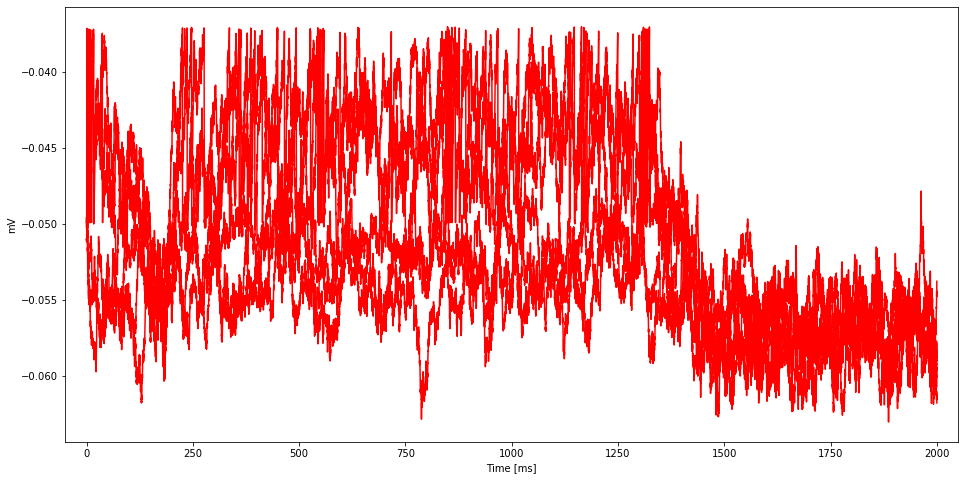

In [6]:
fig2 = plt.figure(figsize=(16, 8))
for ii in random.sample(list(range(N_E)),3): # plotting some exc
    plot(state_mon_E[ii].t/ms, state_mon_E.v[ii].T, 'r')
for ii in random.sample(list(range(N_I)),3): # plotting some exc
    plot(state_mon_I[ii].t/ms, state_mon_I.v[ii].T, 'r')
xlabel('Time [ms]'), xlim(-50,dur*1000 + 50), ylabel('mV')